# W200 Project_2: Relationship Between Inequality and Globalization

Research question to answer:
- What is the relationship between the level of exposure of a country to globalization (world trade) and its ability to reduce income inequality?
- Hypothesis: More exposure to globalization leads to the reduction of income inequality

Starting with some set-up

In [1]:
# doing all the imports
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import ListedColormap
import seaborn as sns

# configuring some pandas options: float display and full display of dataset
# as our datasets are small I still find it worth to visualize the whole thing
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', None)

#setting matplotlib to display charts in this notebook
%matplotlib inline

# importing clean dataset
df = pd.read_csv('final_gini_table_with_new_variables.csv')

# dropping unnamed column
df.drop('Unnamed: 0', axis = 1, inplace = True)

Computing the slope of trade_ratio by country from 2009 to 2018

In [2]:
# selecting the variables relevant for our analysis
df_slope = df[['country', 'year', 'trade_ratio']]

# pivoting the dataframe
df_slope = df_slope.pivot(index = 'country', columns = 'year', values = 'trade_ratio')

# removing rows with values equal to NaN
df_slope = df_slope[df_slope.notnull().all(1)]

# computing the slopes and storing them in the column trade_trend
x = np.arange(2009, 2019, dtype='float64')
df_slope['trade_trend'] = df_slope.apply(lambda row: np.polyfit(x, row, 1)[0], axis = 1)

# dropping the year columns
df_slope.drop(df_slope.columns[:10], axis = 1, inplace = True)
df_slope.reset_index()

# merging new column with df dataset
df = df.merge(df_slope, how = 'left', on = 'country')

## How does exposure to global trade vary among countries?

In [148]:
# filtering 2018
df_2018 = df[df['year'] == '2018-01-01']

# analysing countries with missing trade_ratio values
missing = df_2018[df_2018['trade_ratio'].isnull()]['country']

# ranking countries by trade_ratio
trade_by_country = df_2018.sort_values('trade_ratio')[['country', 'region', 'country_class', 'trade_ratio']].dropna()

# ranking regions by trade_ratio
agg_functions = {'gini_trend': 'mean', 'gini': 'mean', 'gdp': 'sum', 'trade': 'sum', 'trade_trend': 'mean'}
trade_by_region = df_2018.groupby('region').agg(agg_functions)
trade_by_region['trade_ratio'] = trade_by_region['trade'] / trade_by_region['gdp'] * 100
trade_by_region = trade_by_region.sort_values('trade_ratio')['trade_ratio'].reset_index()

# ranking sub_regions by trade_ratio
trade_by_subregion = df_2018.groupby('sub_region').agg(agg_functions)
trade_by_subregion['trade_ratio'] = trade_by_subregion['trade'] / trade_by_subregion['gdp'] * 100
trade_by_subregion = trade_by_subregion.sort_values('trade_ratio')['trade_ratio'].reset_index()

# ranking country_class by trade_ratio
trade_by_countryclass = df_2018.groupby('country_class').agg(agg_functions)
trade_by_countryclass['trade_ratio'] = trade_by_countryclass['trade'] / trade_by_countryclass['gdp'] * 100
trade_by_countryclass = trade_by_countryclass.sort_values('trade_ratio')['trade_ratio'].reset_index()

### Exposure to global trade by country

In [55]:
trade_by_country.describe()

,trade_ratio
count,106.00
mean,97.75
std,65.90
min,27.50
25%,58.72
50%,80.72
75%,117.96
max,387.10


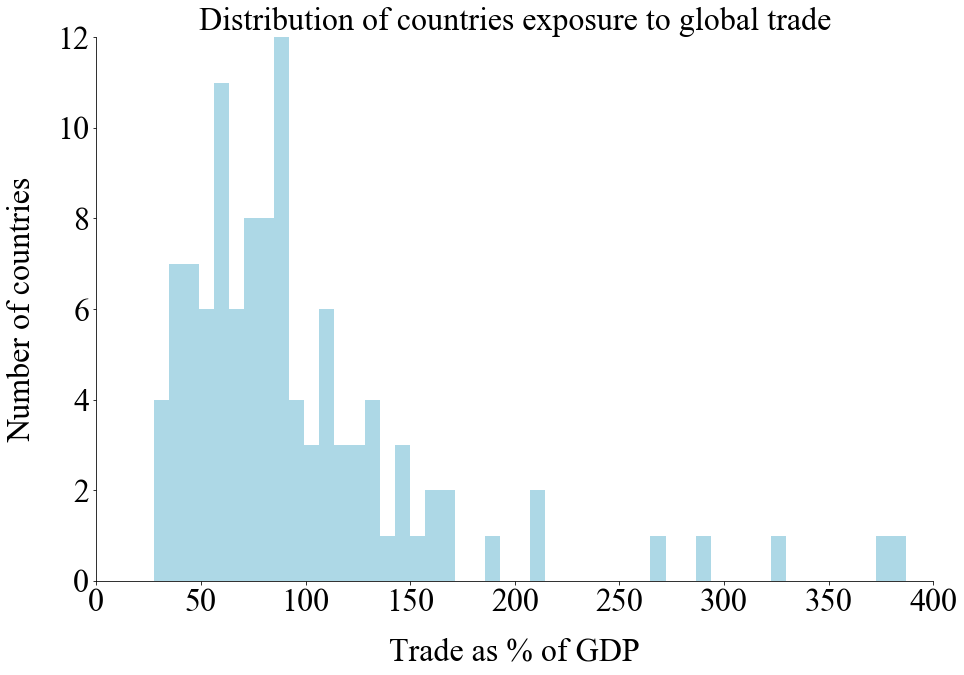

In [113]:
# creating a figure and a subplot
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()

# taking off the top and right lines of the frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plotting a histogram of trade_ratio by country
ax.hist(trade_by_country['trade_ratio'], bins=50, color='lightblue')

# formatting title
plt.title('Distribution of countries exposure to global trade', fontdict={'fontsize':32}, color="k",
            fontname="Times New Roman")

# formatting x-axis
plt.xlabel('Trade as % of GDP', labelpad=20, fontsize=32, fontname="Times New Roman")
plt.xticks(fontsize=32, fontname="Times New Roman")
plt.xlim(0, 400)

# formatting y-axis
plt.ylabel('Number of countries', labelpad=20, fontsize=32, fontname="Times New Roman")
plt.yticks(fontsize=32, fontname="Times New Roman")
plt.ylim(0, 12)

# saving figure as png image
plt.savefig('trade_ratio_histogram.png', dpi = 400)
plt.show()

### Developed vs. developing exposure to global trade

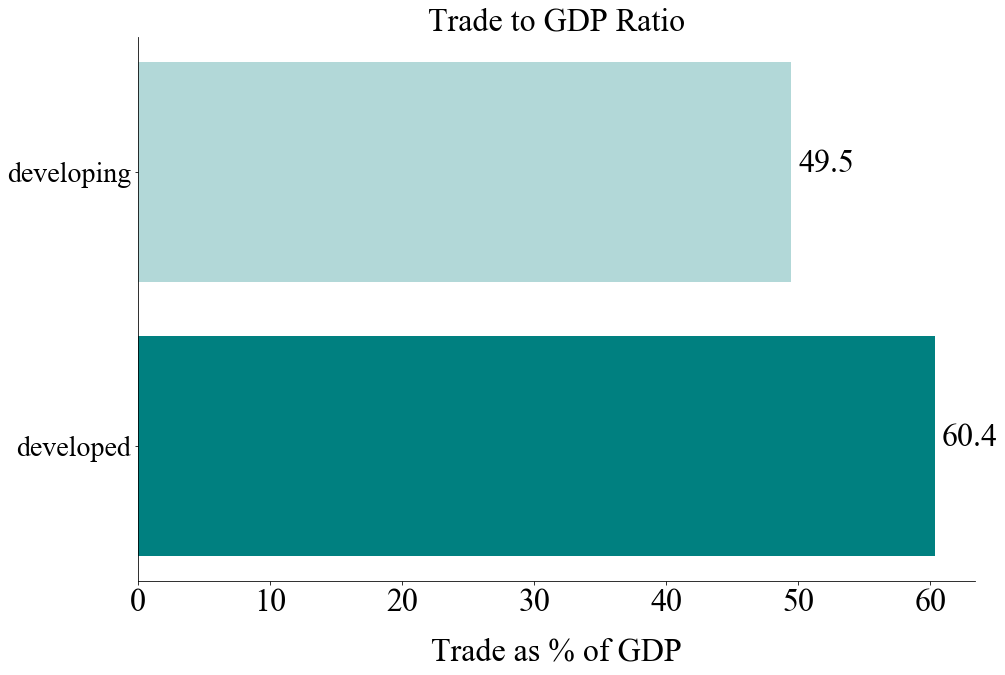

In [130]:
# data to plot
to_plot = trade_by_countryclass.sort_values('trade_ratio', ascending = False)

# creating a figure and a subplot
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot()

# taking off the top and right lines of the frame
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# plotting bars of trade_ratio by country_class
ax.barh(y=to_plot['country_class'], width=to_plot['trade_ratio'], color=('#008080', '#b2d8d8'), align='center')

# formatting title
plt.title('Trade to GDP Ratio', fontdict={'fontsize':32}, color="k",
            fontname="Times New Roman")

# formatting x-axis
plt.xlabel('Trade as % of GDP', labelpad=20, fontsize=32, fontname="Times New Roman")
plt.xticks(fontsize=32, fontname="Times New Roman")

# formatting y-axis
plt.yticks(fontsize=28, fontname="Times New Roman")

# adding bar totals
plt.text(50, 'developing', 49.5, fontsize=32, fontname="Times New Roman")
plt.text(60.9, 'developed', 60.4, fontsize=32, fontname="Times New Roman")

# saving figure as png image
plt.savefig('trade_ratio_bar.png', dpi = 400)
plt.show()

### Top-5 countries more exposed to global trade

In [37]:
top_5 = trade_by_country.sort_values('trade_ratio', ascending = False).head(5)
top_5.set_index('country')

,trade_ratio
country,
Luxembourg,387.10
Hong Kong,376.93
Singapore,326.94
Djibouti,288.22
Malta,268.77


### Bottom-5 countries less exposed to global trade

In [59]:
bottom_5 = trade_by_country.head(5)
bottom_5.set_index('country')

,trade_ratio
country,
United States,27.50
Pakistan,29.04
Brazil,29.40
Ethiopia,31.20
Colombia,36.56


### Exposure to global trade by region

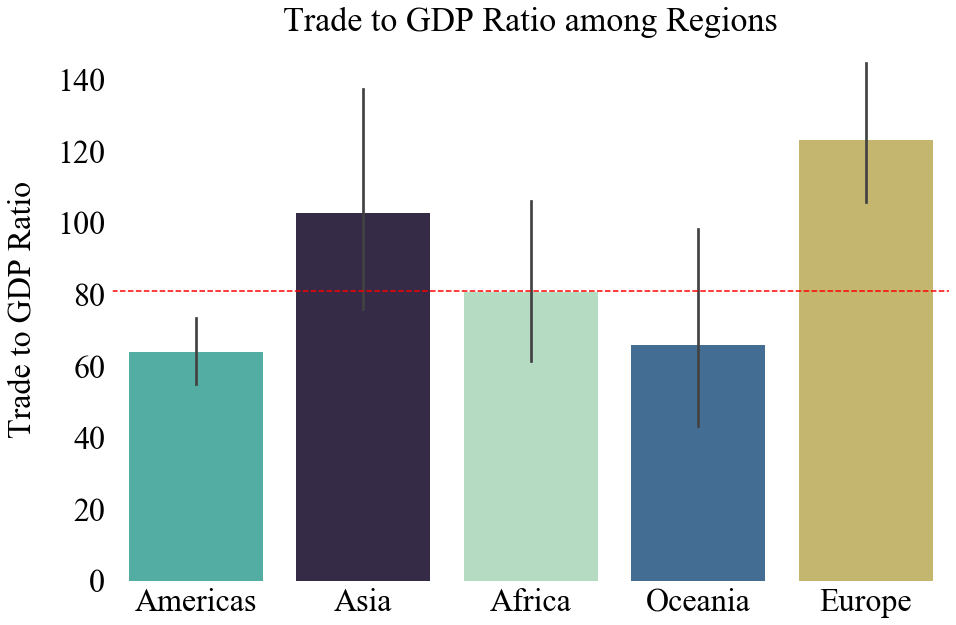

In [144]:
# data to plot
to_plot = trade_by_country

# creating color pallete
my_pal = {"Asia": "#35264c", "Oceania": "#366da0", "Europe":"#d2c060", 
          "Americas":"#44bcad", "Africa":"#aee3c0", "developed": "#35264c", "developing": "#366da0"}

# creating a figure and a plot
fig = plt.figure(figsize=(15,10))
ax = sns.barplot(data=to_plot, x="region", y="trade_ratio", palette=my_pal)

# formatting title
ax.set_title("Trade to GDP Ratio among Regions", fontdict={'fontsize':34}, color="k",
            fontname="Times New Roman")

# formatting x-axis
plt.xlabel("", color="k")
plt.xticks(fontsize=32, fontname="Times New Roman")

# formatting y-axis
plt.ylabel("Trade to GDP Ratio", fontsize=32, fontname="Times New Roman", labelpad=20)
plt.yticks(fontsize=32, fontname="Times New Roman")

# adding axhline with median
ax.axhline(80.99, ls='--', color="red")

# formatting the borders
for pos in ['top', 'right', 'bottom']:
    ax.spines[pos].set_edgecolor("white")
ax.spines["left"].set_edgecolor("white")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False )     # ticks along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False )       # ticks along the left edge are off

# saving figure as png image
plt.savefig('trade_GDP_regions.png', dpi = 400)
plt.show()

## How does inequality vary among countries?

In [153]:
# filtering 2016 (for gini 2016 is the most recent year with lowest number of NaN values)
df_2016 = df[df['year'] == '2016-01-01']

# analysing countries with missing gini values
missing = df_2016[df_2016['gini'].isnull()]['country']

# ranking countries by gini
gini_by_country = df_2016.sort_values('gini')[['country', 'gini']].dropna()

# ranking regions by gini
gini_by_region = df_2016.groupby('region').agg(agg_functions)
gini_by_region = gini_by_region.sort_values('gini')['gini'].reset_index()

# ranking sub_regions by gini
gini_by_subregion = df_2016.groupby('sub_region').agg(agg_functions)
gini_by_subregion = gini_by_subregion.sort_values('gini')['gini'].reset_index().dropna()

# ranking country_class by gini
gini_by_countryclass = df_2016.groupby('country_class').agg(agg_functions)
gini_by_countryclass = gini_by_countryclass.sort_values('gini')['gini'].reset_index()

## Do countries with higher exposure to global trade have lower inequality?

In [154]:
# following dataframes contain trade_ratio of 2018 and gini of 2016

# relationship between trade_ratio and gini at country level
by_country = trade_by_country.merge(gini_by_country, how = 'inner', on = 'country')

# relationship between trade_ratio and gini at region level
by_region = trade_by_region.merge(gini_by_region, how = 'inner', on = 'region')

# relationship between trade_ratio and gini at sub_region level
by_subregion = trade_by_subregion.merge(gini_by_subregion, how = 'inner', on = 'sub_region')

# relationship between trade_ratio and gini at country_class level
by_countryclass = trade_by_countryclass.merge(gini_by_countryclass, how = 'inner', on = 'country_class')

### Relationship between global trade and inequality at country level

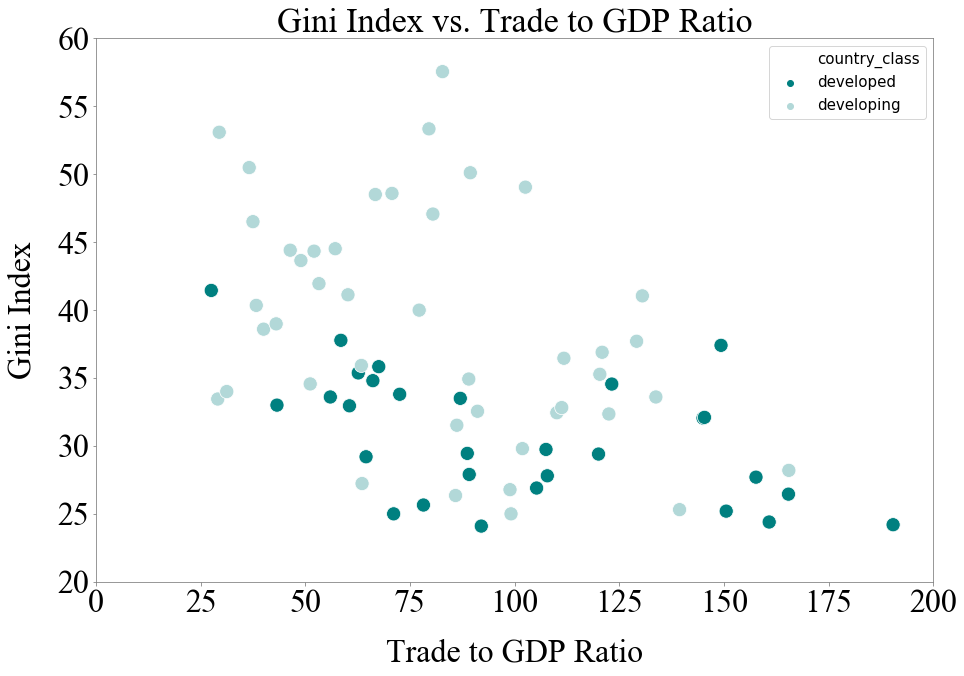

In [173]:
# data to plot
to_plot = by_country

# creating color pallete
regions_pal = {"Asia": "#35264c", "Oceania": "#366da0", "Europe":"#d2c060",
               "Americas":"#44bcad", "Africa":"#aee3c0"}
country_class_pal = {'developed': '#008080', 'developing': '#b2d8d8'}

# creating a figure and a plot
fig = plt.figure(figsize=(15,10))
ax = sns.scatterplot(y="gini", x="trade_ratio", hue="country_class", data=to_plot, s=200, palette=country_class_pal)

# formatting title
ax.set_title("Gini Index vs. Trade to GDP Ratio", fontdict={'fontsize':34}, color="k",
            fontname="Times New Roman")

# formatting x-axis
plt.xlabel("Trade to GDP Ratio", fontsize=32, fontname="Times New Roman", color="k", labelpad=20)
plt.xticks(fontsize=32, fontname="Times New Roman")
plt.xlim(0, 200)
                     
# formatting y-axis
plt.ylabel("Gini Index", fontsize=32, fontname="Times New Roman", color="k", labelpad=20)
plt.yticks(fontsize=32, fontname="Times New Roman")
plt.ylim(20, 60)
                     
# formatting boders
for pos in ['top', 'bottom', 'left', 'right']:
    ax.spines[pos].set_edgecolor("grey")

# Axis ticks
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    color="grey" )     # ticks along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    color="grey")       # ticks along the left edge are off

# formatting legend
plt.legend(prop={'size': 15})

# saving figure as png image
plt.savefig('trade_gini_scatter.png', dpi = 400)
plt.show()

In [170]:
to_plot.corr()

,trade_ratio,gini
trade_ratio,1.00,-0.25
gini,-0.25,1.00


### Relationship between global trade and inequality at region level

In [70]:
by_region

,region,trade_ratio,gini
0,Americas,33.90,43.96
1,Oceania,44.67,33.30
2,Asia,54.54,36.91
3,Africa,59.26,41.48
4,Europe,87.42,29.70


Do countries that have increased integration reduced inequality faster?

In [175]:
# filtering the relevant columns
df_trend = df[['country', 'region', 'sub_region', 'country_class', 'gini_trend', 'trade_trend']]

# excluding rows with NaN values
df_trend = df_trend[df_trend.notnull().all(1)]

# relationship between trade_trend and gini_trend at country level
t_by_country = df_trend.groupby('country').mean().sort_values('trade_trend').reset_index()

# relationship between trade_trend and gini_trend at region level
t_by_region = df_trend.groupby('region').mean().sort_values('trade_trend').reset_index()

# relationship between trade_trend and gini_trend at sub_region level
t_by_subregion = df_trend.groupby('sub_region').mean().sort_values('trade_trend').reset_index()

# relationship between trade_trend and gini_trend at country_class level
t_by_countryclass = df_trend.groupby('country_class').mean().sort_values('trade_trend').reset_index()

### Relationship between change in trade and change in inequality

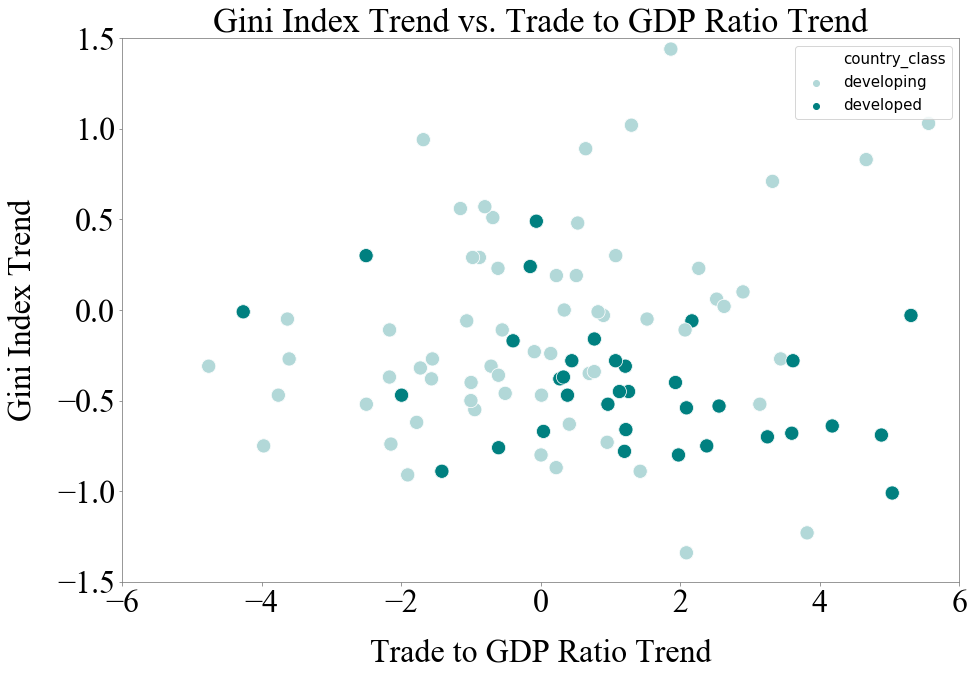

In [181]:
to_plot = df_trend

# creating color pallete
regions_pal = {"Asia": "#35264c", "Oceania": "#366da0", "Europe":"#d2c060",
               "Americas":"#44bcad", "Africa":"#aee3c0"}
country_class_pal = {'developed': '#008080', 'developing': '#b2d8d8'}

# creating a figure and a plot
fig = plt.figure(figsize=(15,10))
ax = sns.scatterplot(y="gini_trend", x="trade_trend", hue="country_class", data=to_plot, s=200, palette=country_class_pal)

# formatting title
ax.set_title("Gini Index Trend vs. Trade to GDP Ratio Trend", fontdict={'fontsize':34}, color="k",
            fontname="Times New Roman")

# formatting x-axis
plt.xlabel("Trade to GDP Ratio Trend", fontsize=32, fontname="Times New Roman", color="k", labelpad=20)
plt.xticks(fontsize=32, fontname="Times New Roman")
plt.xlim(-6, 6)
                     
# formatting y-axis
plt.ylabel("Gini Index Trend", fontsize=32, fontname="Times New Roman", color="k", labelpad=20)
plt.yticks(fontsize=32, fontname="Times New Roman")
plt.ylim(-1.5, 1.5)
                     
# formatting boders
for pos in ['top', 'bottom', 'left', 'right']:
    ax.spines[pos].set_edgecolor("grey")

# Axis ticks
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    color="grey" )     # ticks along the bottom edge are off
plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    color="grey")       # ticks along the left edge are off

# formatting legend
plt.legend(prop={'size': 15})

# saving figure as png image
plt.savefig('trade_gini_trend_scatter.png', dpi = 400)
plt.show()

In [185]:
df_trend.corr()

,gini_trend,trade_trend
gini_trend,1.00,0.00
trade_trend,0.00,1.00
